In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style('whitegrid')

df = pd.read_csv('../../results-new-sliced/n_vs_f_two_exp-180.csv')

In [2]:
df['spot_fraction'] = df['avg_spot_hours'] / (df['avg_spot_hours'] + df['avg_wait_hours'])

In [3]:
groups = [x for _, x in df.groupby(['spot_fraction', 'restart_overhead_hours'])]

max_optimal_n_within_range = []

for group in groups:
    min_cost = group['avg_cost'].min()
    group['relative_cost'] = group['avg_cost'] / min_cost
    group = group[group['relative_cost'] < 1.01]
    max_n = group.loc[group['num_slices'].idxmax()]
    max_optimal_n_within_range.append(max_n)
    # max_optimal_n_within_range.append(group.loc[group['relative_cost'].idxmin()])

max_optimal_n_within_range = pd.DataFrame(max_optimal_n_within_range)

<Axes: xlabel='spot_fraction', ylabel='num_slices'>

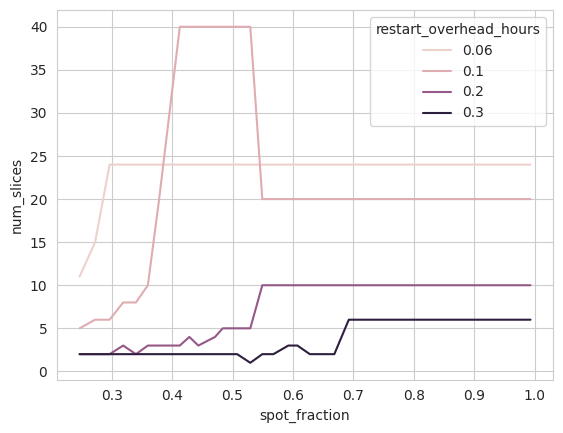

In [6]:
sns.lineplot(x='spot_fraction', y='num_slices', hue='restart_overhead_hours', data=max_optimal_n_within_range)

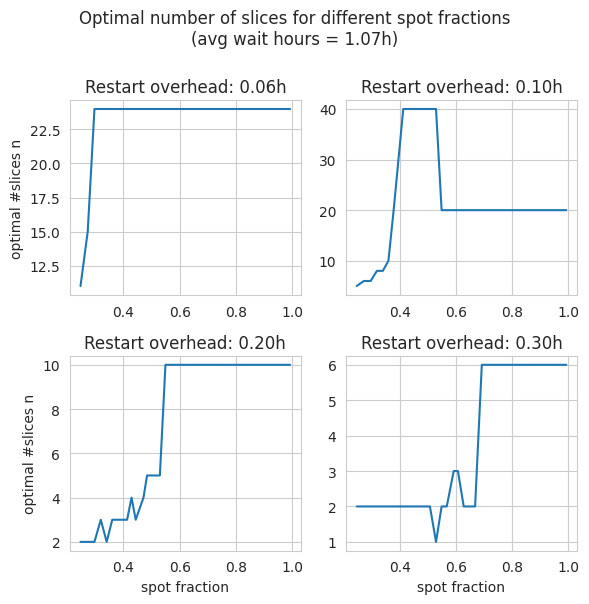

In [17]:
skip = 1
fig = plt.figure(figsize=(6, 6),
                #  dpi=300,
                 )
restart_overhead_hours = max_optimal_n_within_range['restart_overhead_hours'].sort_values().unique()
axes = fig.subplots((len(restart_overhead_hours) + 1) // 2 // skip, 2)
for i, overhead in enumerate(restart_overhead_hours[::skip]):
    ax = axes[i//2, i%2]
    data = max_optimal_n_within_range[np.isclose(max_optimal_n_within_range['restart_overhead_hours'], overhead)]
    # data = data[data['restart_overhead_hours'] <= 0.3]
    sns.lineplot(x=data['spot_fraction'],
                 y=data['num_slices'], ax=ax)
    ax.set_title(f'Restart overhead: {overhead:.2f}h')
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xlim(0, 0.5)
    # if i < 2:
    #     ax.set_ylim(0, 52)
    # else:
    #     ax.set_ylim(0, 25)

for ax in axes[-1, :]:
    ax.set_xlabel('spot fraction')

for ax in axes[:, 0]:
    ax.set_ylabel('optimal #slices n')


fig.suptitle(
    f'Optimal number of slices for different spot fractions\n(avg wait hours = {data["avg_wait_hours"].iloc[0]:.2f}h)', y=1.0)
fig.tight_layout()

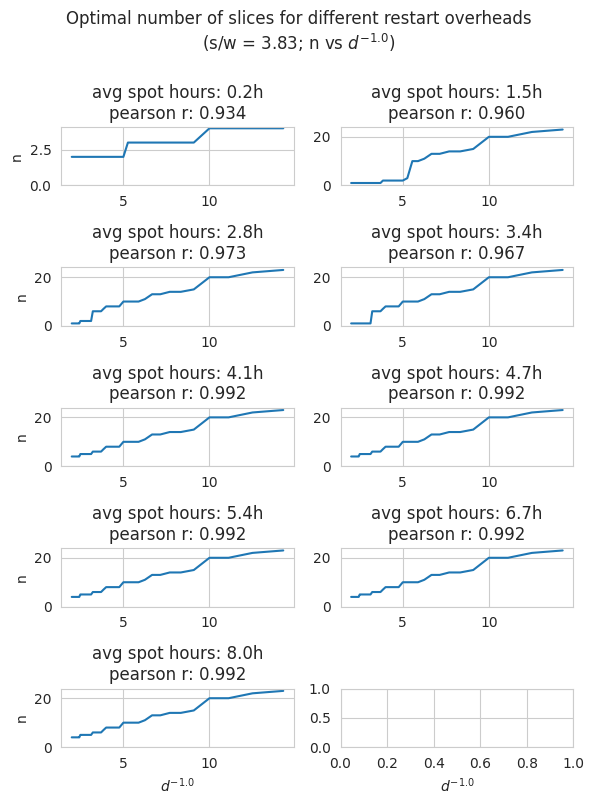

In [18]:
skip = 1
exp_scale = -1
fig = plt.figure(figsize=(6, 8),
                #  dpi=300,
                 )
spot_hours = max_optimal_n_within_range['avg_spot_hours'].sort_values().unique()
axes = fig.subplots((len(spot_hours) + 1) // 2 // skip, 2)
for i, spot_hour in enumerate(spot_hours[::skip]):
    ax = axes[i//2, i%2]
    data = max_optimal_n_within_range[np.isclose(max_optimal_n_within_range['avg_spot_hours'], spot_hour)]
    data = data[data['restart_overhead_hours'] > 0.06]
    x = data['restart_overhead_hours'] ** exp_scale
    y = data['num_slices']
    pr = np.corrcoef(x, y)[0, 1]
    sns.lineplot(x=x, y=y, ax=ax)
    ax.set_title(f'avg spot hours: {spot_hour:.1f}h\npearson r: {pr:.3f}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xlim(0, 0.5)
    ax.set_ylim(0, None)

for ax in axes[-1, :]:
    ax.set_xlabel(f'$d^{{{exp_scale:.1f}}}$')

for ax in axes[:, 0]:
    ax.set_ylabel('n')

s_w = max_optimal_n_within_range['avg_spot_hours'].iloc[0] / max_optimal_n_within_range['avg_wait_hours'].iloc[0]
fig.suptitle(
    f'Optimal number of slices for different restart overheads\n(s/w = {s_w:.2f}; n vs $d^{{{exp_scale:.1f}}}$)',
    y=1.0)
fig.tight_layout()

## Trace analysis


43200522


Text(0.5, 1.0, 'v vs. $n^{0.5}$ (pearson r: 0.999)')

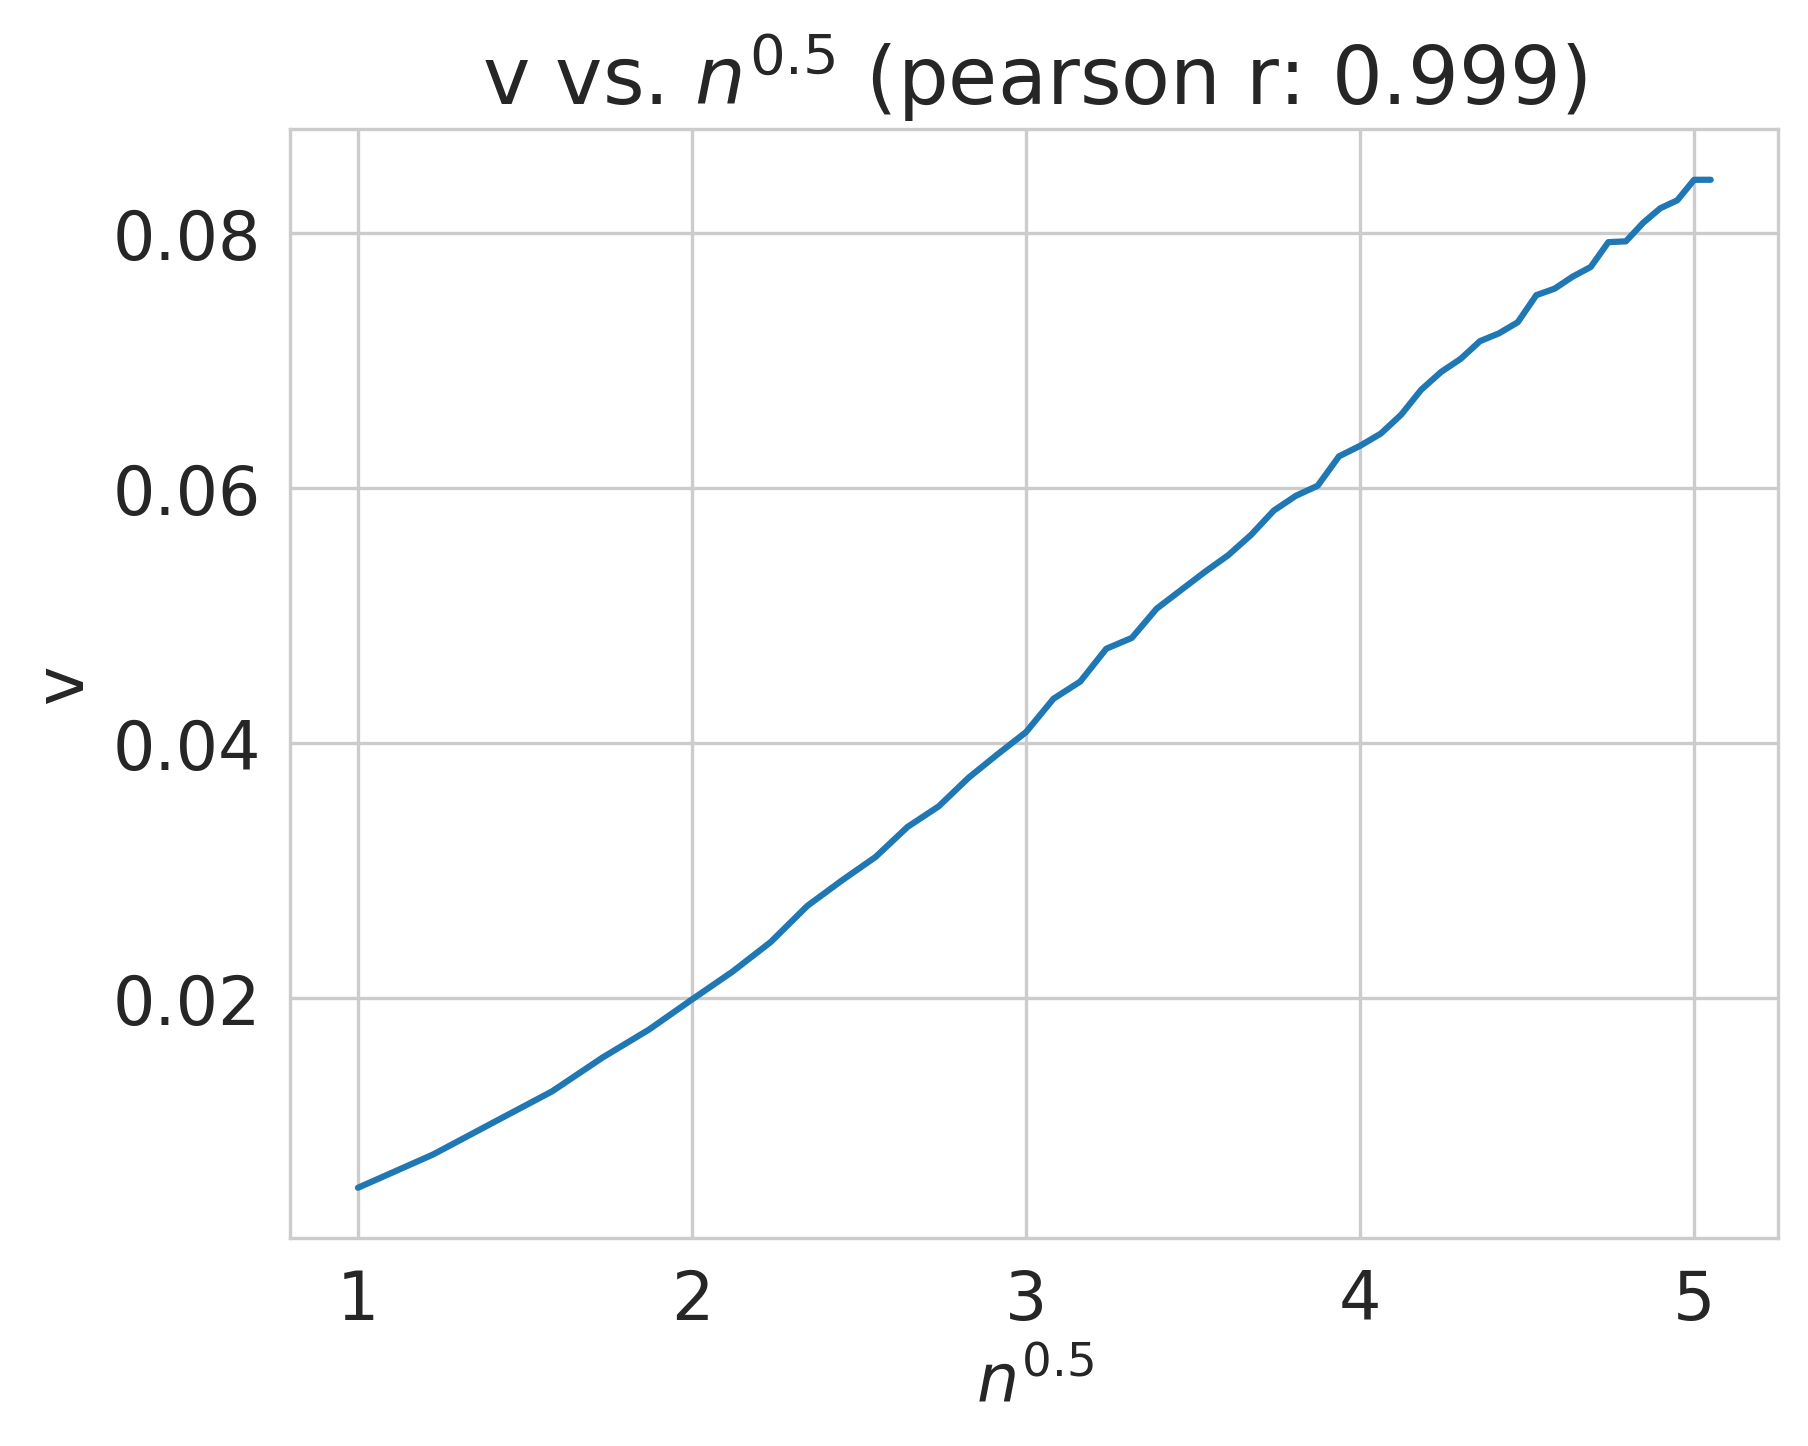

In [21]:
import os
import json

plt.rc('font', size=16)


TRACE_PATH = '../../exp-time-sliced/n_vs_d/two_exp/gap=60/spot=245.00-wait=64.00/traces/raw/0.json'

# Traverse the trace directory and collect all the traces
trace = 1-np.array(json.load(open(TRACE_PATH))['data'])
L = len(trace)
print(L)

vars = []
start = 1
x = np.arange(start, 52, 0.5)
for n in x:
    interval_hours = 52/n
    interval_gaps = int(interval_hours * 3600 / 60)
    slice_spot_frac = trace[:L-(L%interval_gaps)].reshape(-1, interval_gaps)[:10000,:].mean(axis=1)
    vars.append(slice_spot_frac.var())
vars = np.array(vars)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
exp_scale = .5
new_x = x**exp_scale
sns.lineplot(x=new_x, y=vars, ax=ax)
ax.set_xlabel(f'$n^{{{exp_scale}}}$')
ax.set_ylabel('v')
ax.set_title(f'v vs. $n^{{{exp_scale}}}$ (pearson r: {np.corrcoef(new_x, vars)[0, 1]:.3f})')
